In [1]:
%matplotlib inline

import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# function used to call train_test_split to split the data in 75% for training and 25% for testing
def split_train_test(inputs, outputs):
    return train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

# function used to train the model (search) with the training data (in_train, out_train), also gives the time elapsed
def train_model(params, search, in_train, out_train):
    start = time.time()
    search.fit(in_train, out_train)
    end = time.time()
    elapsed_time = end - start
    print('Elapsed time: {}mins'.format(elapsed_time / 60))
    print('Best score: {}'.format(search.best_score_))
    print('Best parameters: {}'.format(search.best_params_))
    return search.best_estimator_
    
# function used to plot a bar graph to compare the data ploted using the trained model (estimator) with the actual real results (out_test)
# Also gives some statistical parameters like the Mean Absolute Error (MAE),Mean Squared Error (MSE), Root Mean Squared Error (RMSE)
# and finally the (R^2).
def check_results_test(estimator, in_test, out_test, label):
    estimator_pred = estimator.predict(in_test)
    plt.plot(out_test)
    plt.plot(estimator_pred)
    plt.legend(['Input Data', label])
    print('MAE:', mean_absolute_error(out_test, estimator_pred))
    print('MSE:',mean_squared_error(out_test, estimator_pred))
    print('RMSE:', math.sqrt(mean_squared_error(out_test, estimator_pred)))
    print('R^2:', r2_score(out_test, estimator_pred))
    
# function used to calculate and plot the cross validation score when using a trained model (estimator) and applying it
# to the inputs (inputs) and finally comparing it with the outputs (outputs).
def plot_cross_val_score(estimator, inputs, outputs, number_cv):
    cv_scores = cross_val_score(estimator, inputs, outputs, cv=number_cv)
    plt.hist(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    
# function used to convert data from increments into cumulative data    
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list
    
# function used to predict  a attribute (output), for a certain country (country) using as input an array of 
# attributes (inputs_list). This prediction is done using a trained model (estimator) and using input and output data 
# from the certain country (country_inputs, country_outputs). When cumulative is True it means we are predicting
# a cumulative attribute and otherwise a incremental attribute. 
def plot_predictions_for_country(df, country, estimator, inputs_list, output, label_out, label_pred, title, cumulative=False):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs) 

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    if cumulative:
        country_pred_output = calc_cumulative(country_pred_output)
    
    print('MAE:', mean_absolute_error(country_outputs, country_pred_output))
    print('MSE:',mean_squared_error(country_outputs, country_pred_output))
    print('RMSE:', math.sqrt(mean_squared_error(country_outputs, country_pred_output)))
    print('R^2:', r2_score(country_outputs, country_pred_output))

    plt.plot(days_list, country_outputs, color='blue', label=label_out)
    plt.plot(days_list, country_pred_output, color='green', label=label_pred)
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(title + "(as of {})".format(last_day))
    plt.legend()

    
# function used to plot a learning curve using a trained model (estimator) and inputs (inputs) and outputs(outputs)
# to test the model itself
def plot_learning_curve(estimator, inputs, outputs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True,
                                       random_state=None, error_score=np.nan, return_times=False)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    
    
# function used to plot a bar graph representing the diference between the actual output values  for a country (country_outputs),
# obtained using the "output" variable ,and the ones predicted by a trained model (estimator) for a certain attribute (output) using 
# as input an array of values (country_inputs) obtained from the array "inputs_list" for that certain country
def plot_pred_diff(df, estimator, country, inputs_list, output):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs)

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    diff_list = np.subtract(country_outputs, country_pred_output)
    plt.bar(days_list, diff_list, color='blue', label="")
    plt.show()

# 3.2) Neural Networks
- - -

In [3]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


### Approach (Multi-layer Perceptron)

#### Brief description of the algorithm

A multilayer perceptron (MLP) is a class of feedforward artificial neural network (ANN). The term MLP is used ambiguously, sometimes loosely to refer to any feedforward ANN, sometimes strictly to refer to networks composed of multiple layers of perceptrons (with threshold activation).Multilayer perceptrons are sometimes colloquially referred to as "vanilla" neural networks, especially when they have a single hidden layer.

An MLP consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. ts multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.

#### Steps taken to make the algorith start predicting values

In order to make MLPRegressor start predicting values the first step needed was to do hyper parameter tuning using cross validation but unfortunately this step proved to be taking too long so it was abandoned due to time constraints. 

After that the model was trained using training data and at the end the model was ready to be tested and used to predict values.
It was decided it would be in the best of interests to predict values for the confimed cases first, using the following combinations of inputs and outputs:

1) Using non normalized values as input and cummulative as output
    inputs: lat, long, num_days_from_begin
    outputs: confirmed
   
2) Using normalized values as input and using increments as output
    inputs: lat_norm, long_norm, num_days_from_begin_norm
    outputs: confirmed_inc

3) Using non normalized values and increment in confirmed values as output
    inputs: lat, long, num_days_from_begin
    outputs: confirmed_inc
    
4) Using increases in confirmed cases and normalized values, using increase as output
    inputs: lat_norm, long_norm, num_days_from_begin_norm, confirmed_inc_day_before_norm
    outputs: confirmed_inc
    
From this four combinations, one was chosen, the one with the best predictions, and used to predict the deaths and the recovered number of cases. In order to find out which combination was the best, a number of scalar parameters like the MAE, MSE, RMSE and R^2 were used to compare iterations aswell as some graphs. In the end it was discovered that the best combination was the third one using as input the normalized values of the lat, long, num_days_from_begin and confirmed_inc_day_before and as output the increment in confirmed cases.

In order to compare values in a consistent way all the graphs related to countries were always made for the same 6 countries: US, Spain, Portugal, Italy, Russia and Brazil.

## 3.1.1) Regression for Confirmed Cases
- - -

### Using normalized values as input and using increments as output

In [4]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [5]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [6]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [7]:
mlp = MLPRegressor(verbose=0, max_iter=1000)
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [8]:
# NOTE: hyper parameter tuning was not performed for the neural networks because it took too long to conclude.
# A simple fit and predict was made.
mlp_estimator = mlp
fit_model(mlp_estimator, in_conf_train, out_conf_train)
mlp_estimator

Elapsed time: 1.283281648159027mins


C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

MAE: 296.61863292965234
MSE: 1813323.0406303455
RMSE: 1346.5968367073885
R^2: 0.09729093086161833


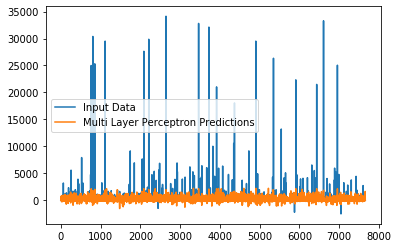

In [9]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'Multi Layer Perceptron Predictions')

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

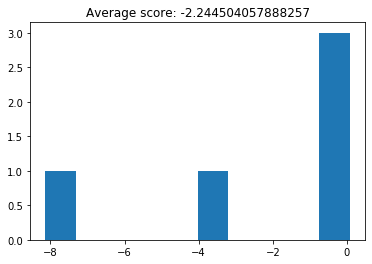

In [10]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

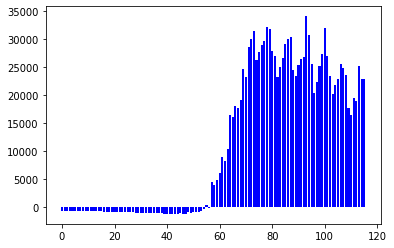

In [11]:
plot_pred_diff(
    df, mlp_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed_inc"
)

MAE: 312066.964956186
MSE: 266272041557.0784
RMSE: 516015.5439103345
R^2: -0.14763824789611668


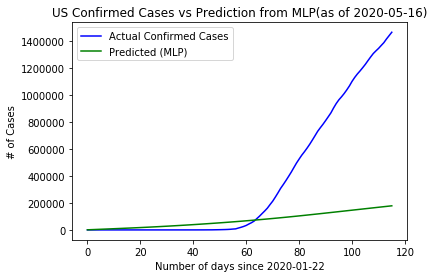

In [12]:
plot_predictions_for_country(
    df, "US", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "US Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 25017.058327060946
MSE: 2671537747.7395573
RMSE: 51686.920470652505
R^2: 0.10520896408750535


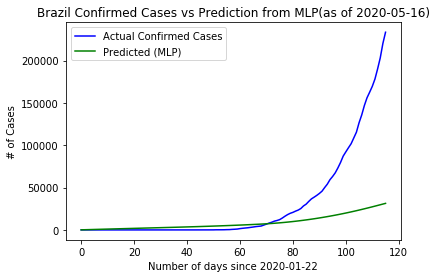

In [13]:
plot_predictions_for_country(
    df, "Brazil", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Brazil Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 70752.129006955
MSE: 11352576394.523823
RMSE: 106548.4696958329
R^2: -0.31098981210926824


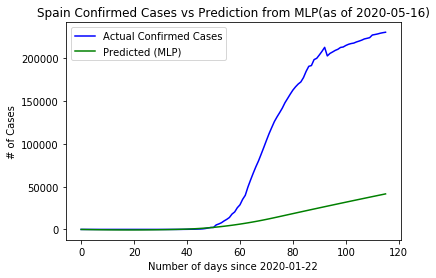

In [14]:
plot_predictions_for_country(
    df, "Spain", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Spain Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 4229.575952799541
MSE: 34174794.36063197
RMSE: 5845.921172974536
R^2: 0.7022946102239152


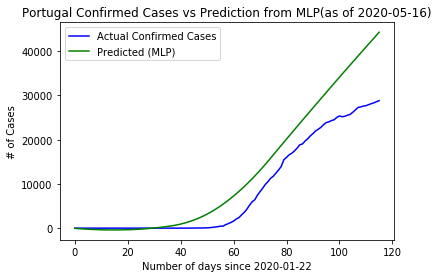

In [15]:
plot_predictions_for_country(
    df, "Portugal", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Portugal Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 31923.306696008334
MSE: 3725783557.730911
RMSE: 61039.1968961823
R^2: 0.22418094530853927


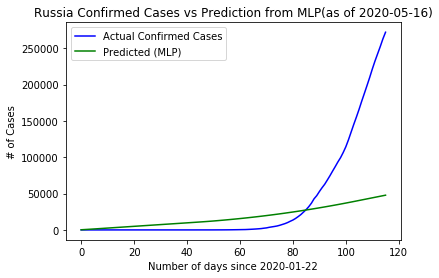

In [16]:
plot_predictions_for_country(
    df, "Russia", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Russia Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 73235.76750358698
MSE: 11034382637.21349
RMSE: 105044.66972299684
R^2: -0.4627224325252812


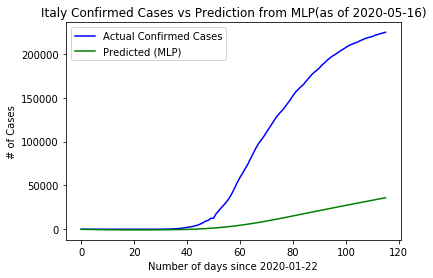

In [17]:
plot_predictions_for_country(
    df, "Italy", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Italy Confirmed Cases vs Prediction from MLP",
    True
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

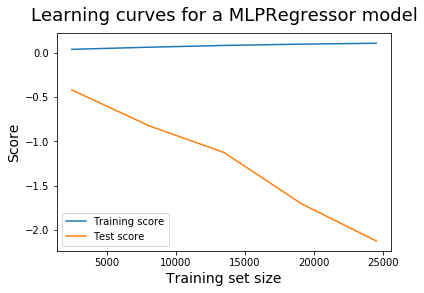

In [18]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)

### Using non normalized values and increment in confirmed values as output


In [19]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [20]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [21]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [22]:
mlp_estimator = mlp
fit_model(mlp_estimator, in_conf_train, out_conf_train)
mlp_estimator

Elapsed time: 1.3784751057624818mins


C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

MAE: 309.00809173648565
MSE: 1492952.6888534
RMSE: 1221.8644314544065
R^2: 0.16995371884259902


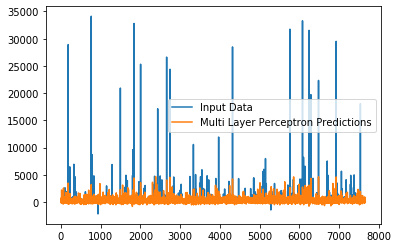

In [23]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'Multi Layer Perceptron Predictions')

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

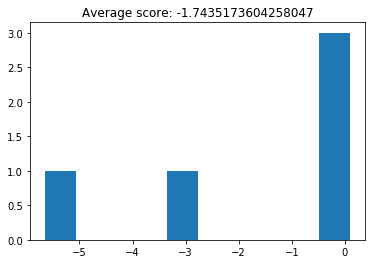

In [24]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

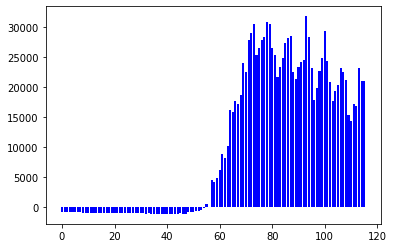

In [25]:
plot_pred_diff(
    df, mlp_estimator,
    "US", 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed_inc"
)

MAE: 297573.7851917715
MSE: 238227445045.23068
RMSE: 488085.48948440445
R^2: -0.026765431450191723


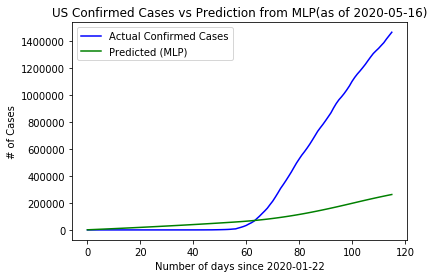

In [26]:
plot_predictions_for_country(
    df, "US", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "US Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 20736.11044307494
MSE: 1788488048.2727149
RMSE: 42290.51960277522
R^2: 0.4009730632535048


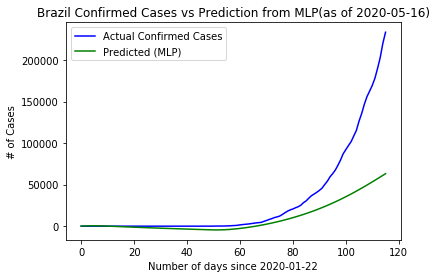

In [27]:
plot_predictions_for_country(
    df, "Brazil", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Brazil Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 64613.710994159555
MSE: 9242389545.915565
RMSE: 96137.34730018073
R^2: -0.06730649617872397


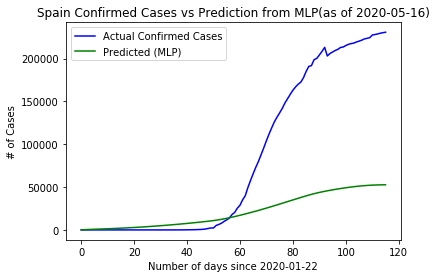

In [28]:
plot_predictions_for_country(
    df, "Spain", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Spain Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 10761.763982241637
MSE: 168718732.26185796
RMSE: 12989.177505210173
R^2: -0.46975210503108555


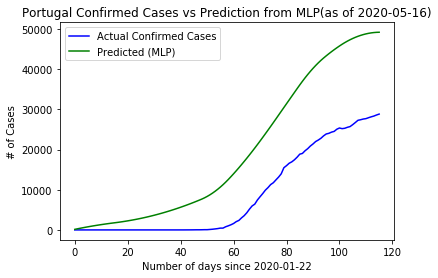

In [29]:
plot_predictions_for_country(
    df, "Portugal", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Portugal Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 22680.321936990564
MSE: 2658519948.7480745
RMSE: 51560.83735499332
R^2: 0.4464170015361142


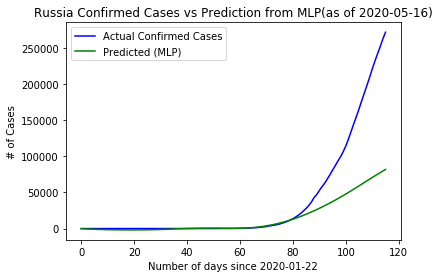

In [30]:
plot_predictions_for_country(
    df, "Russia", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Russia Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 70071.81406343263
MSE: 10279810538.7485
RMSE: 101389.40052465297
R^2: -0.36269603579148635


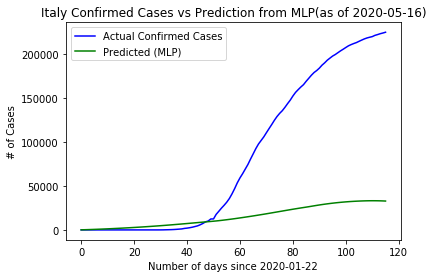

In [31]:
plot_predictions_for_country(
    df, "Italy", mlp_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Italy Confirmed Cases vs Prediction from MLP",
    True
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

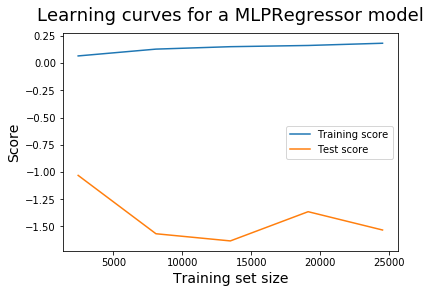

In [32]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)

### Using increases in confirmed cases and normalized values, using increase as output

In [33]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [34]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = new_df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [35]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [36]:
mlp_estimator = mlp
fit_model(mlp_estimator, in_conf_train, out_conf_train)
mlp_estimator

Elapsed time: 0.28594613472620645mins


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

MAE: 47.53652073332487
MSE: 167913.18955426323
RMSE: 409.77211905431443
R^2: 0.9199498925821669


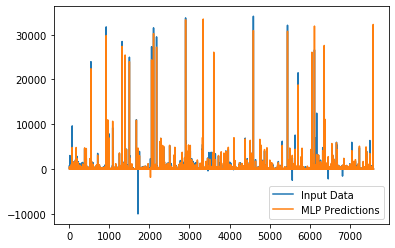

In [37]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'MLP Predictions')

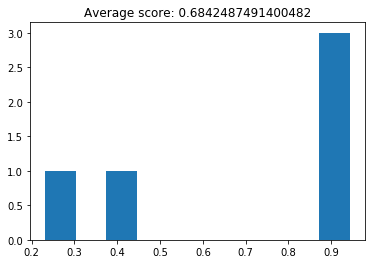

In [38]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

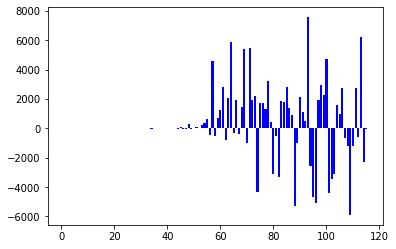

In [39]:
plot_pred_diff(
    new_df, mlp_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed_inc"
)

MAE: 15632.029668585457
MSE: 526485418.21029717
RMSE: 22945.270061829673
R^2: 0.9977396963616088


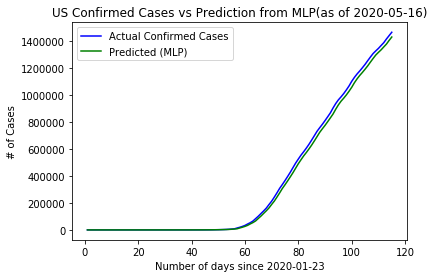

In [40]:
plot_predictions_for_country(
    new_df, "US", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "US Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 1570.7623739943108
MSE: 10523970.434267595
RMSE: 3244.066958967955
R^2: 0.996496125301268


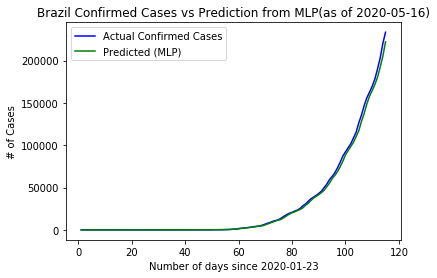

In [41]:
plot_predictions_for_country(
    new_df, "Brazil", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Brazil Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 3216.536337162164
MSE: 23621984.413909435
RMSE: 4860.245303882247
R^2: 0.9972771164434976


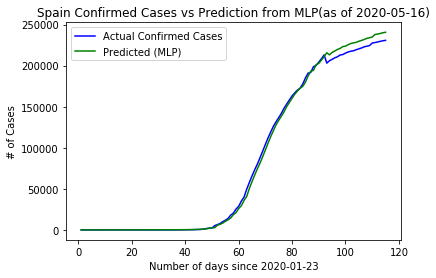

In [42]:
plot_predictions_for_country(
    new_df, "Spain", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Spain Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 301.6983628512984
MSE: 180629.24919370294
RMSE: 425.00499902201494
R^2: 0.9984310184607879


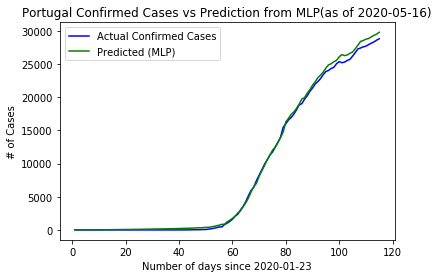

In [43]:
plot_predictions_for_country(
    new_df, "Portugal", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Portugal Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 2099.6810522864675
MSE: 13785052.217604345
RMSE: 3712.8226752168416
R^2: 0.9971473932767752


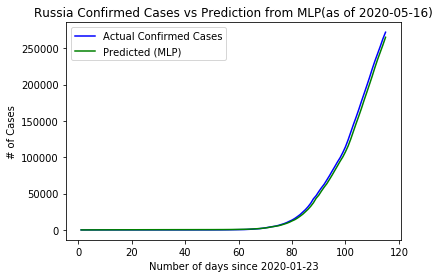

In [44]:
plot_predictions_for_country(
    new_df, "Russia", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm","Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Russia Confirmed Cases vs Prediction from MLP",
    True
)

MAE: 1300.4429292602633
MSE: 3843107.5300618727
RMSE: 1960.3845362739098
R^2: 0.999490918846281


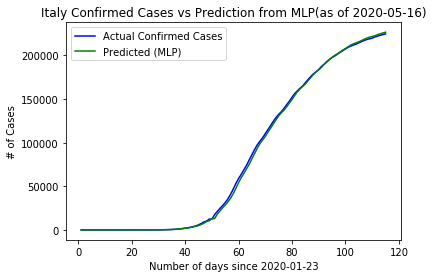

In [45]:
plot_predictions_for_country(
    new_df, "Italy", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Italy Confirmed Cases vs Prediction from MLP",
    True
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


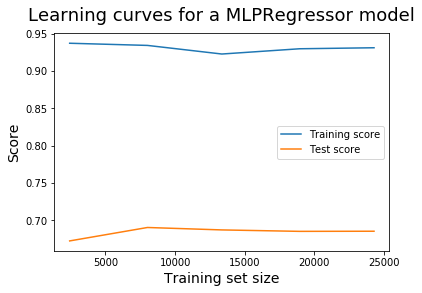

In [46]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)

### Normalized inputs, cumulative as outputs

In [47]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [48]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42], dtype=int64)

In [49]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [50]:
mlp_estimator = mlp
fit_model(mlp_estimator, in_conf_train, out_conf_train)
mlp_estimator

Elapsed time: 1.211832869052887mins


C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

MAE: 6748.366638439496
MSE: 874526926.6055264
RMSE: 29572.401434539035
R^2: 0.048021321992706256


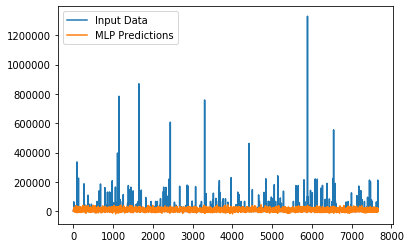

In [51]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'MLP Predictions')

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

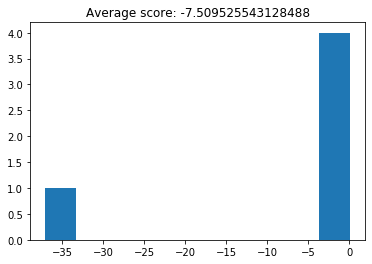

In [52]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

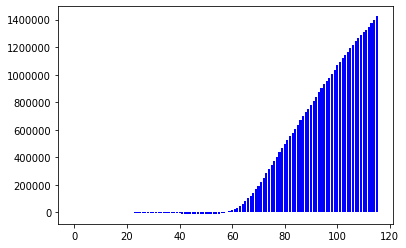

In [53]:
plot_pred_diff(
    df, mlp_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed"
)

MAE: 342394.17299490474
MSE: 333877763441.1023
RMSE: 577821.5671304613
R^2: -0.4390203688166179


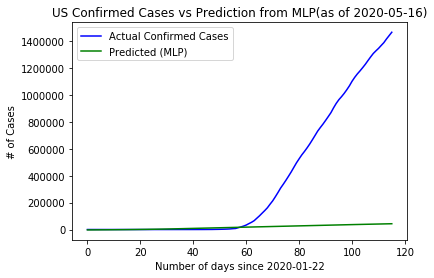

In [54]:
plot_predictions_for_country(
    df, "US", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "US Confirmed Cases vs Prediction from MLP",
)

MAE: 29580.640464786182
MSE: 3676522170.571098
RMSE: 60634.33161642913
R^2: -0.231395320670301


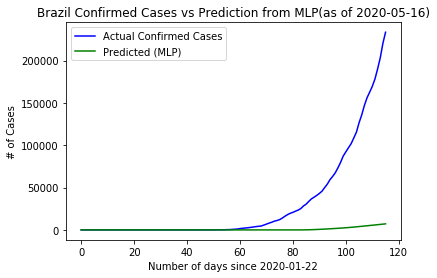

In [55]:
plot_predictions_for_country(
    df, "Brazil", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Brazil Confirmed Cases vs Prediction from MLP",
)

MAE: 72957.49418512672
MSE: 12139043258.73187
RMSE: 110177.32642759067
R^2: -0.4018106100239711


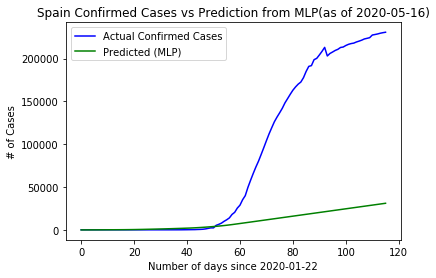

In [56]:
plot_predictions_for_country(
    df, "Spain", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Spain Confirmed Cases vs Prediction from MLP",
)

MAE: 1773.7613862850671
MSE: 6444969.666260165
RMSE: 2538.694480684938
R^2: 0.943856217938233


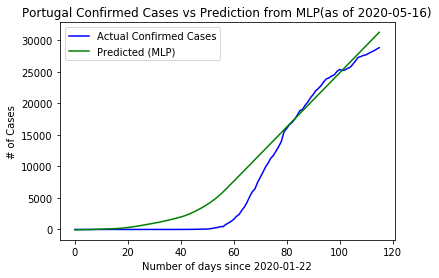

In [57]:
plot_predictions_for_country(
    df, "Portugal", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Portugal Confirmed Cases vs Prediction from MLP",
)

MAE: 32543.20386694922
MSE: 4713629450.03298
RMSE: 68655.87702471639
R^2: 0.01848202198906901


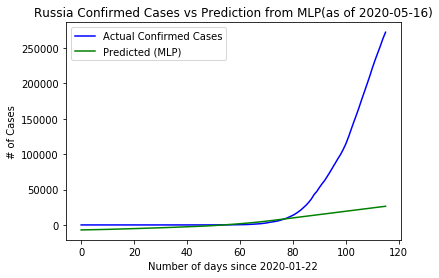

In [58]:
plot_predictions_for_country(
    df, "Russia", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Russia Confirmed Cases vs Prediction from MLP",
)

MAE: 73350.28631861595
MSE: 11284033201.227297
RMSE: 106226.33007511507
R^2: -0.49581621695179257


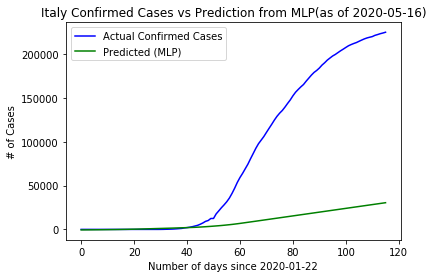

In [59]:
plot_predictions_for_country(
    df, "Italy", mlp_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (MLP)", 
    "Italy Confirmed Cases vs Prediction from MLP",
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

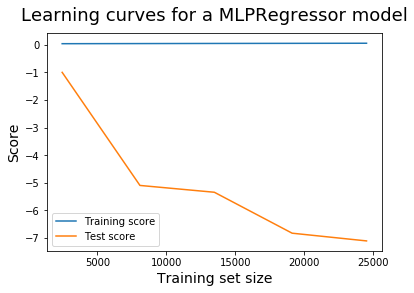

In [60]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)

## 3.4.2) Regression for Death Cases
### Using the best combination of parameters found for the confirmed deaths: for the Multi Layer Perceptron, the best option tested was using increases in confirmed cases and normalized values and using increases as output

In [90]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Deaths_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11017732],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11017732],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11017732],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11017732],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11017732],
       [-1.65599721,  0.09994051,  1.71718314, -0.11017732]])

In [91]:
outputs = new_df["Deaths_inc"].values
outputs

array([0., 0., 0., ..., 0., 0., 0.])

In [92]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [93]:
mlp_estimator = mlp
fit_model(mlp_estimator, in_conf_train, out_conf_train)
mlp_estimator

Elapsed time: 0.749320634206136mins


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

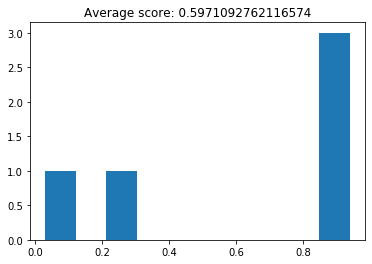

In [66]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

MAE: 4.2703971774799605
MSE: 823.78154847246
RMSE: 28.70159487680885
R^2: 0.9196939261813366


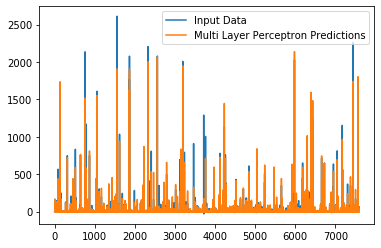

In [94]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'Multi Layer Perceptron Predictions')

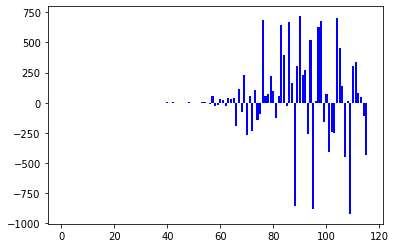

In [68]:
plot_pred_diff(
    new_df, mlp_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths_inc"
)

MAE: 932.040868260112
MSE: 2806286.655757144
RMSE: 1675.1974975378707
R^2: 0.9965835810206917


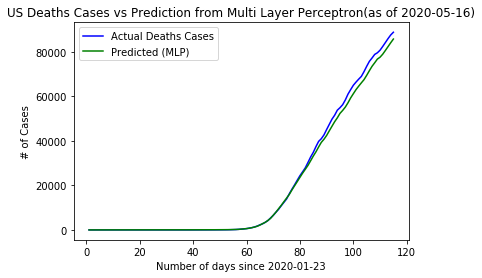

In [69]:
plot_predictions_for_country(
    new_df, "US", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "US Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 78.78478715051028
MSE: 20973.413734118705
RMSE: 144.8220070780636
R^2: 0.9985223940818181


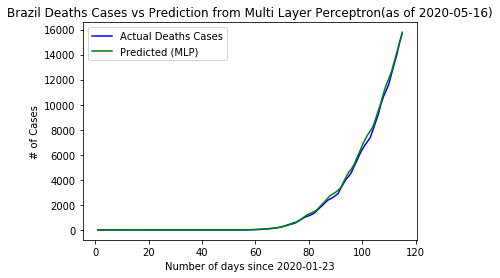

In [70]:
plot_predictions_for_country(
    new_df, "Brazil", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "Brazil Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 230.330831376918
MSE: 128115.00168506485
RMSE: 357.9315600573172
R^2: 0.9988535461280973


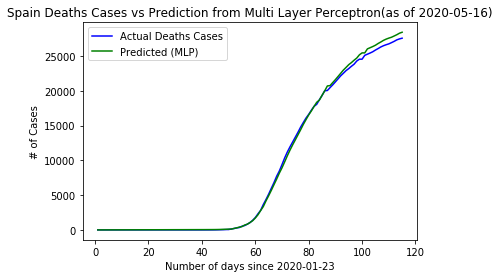

In [71]:
plot_predictions_for_country(
    new_df, "Spain", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "Spain Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 61.06297998051775
MSE: 5679.014016264761
RMSE: 75.35923311887377
R^2: 0.968932556414484


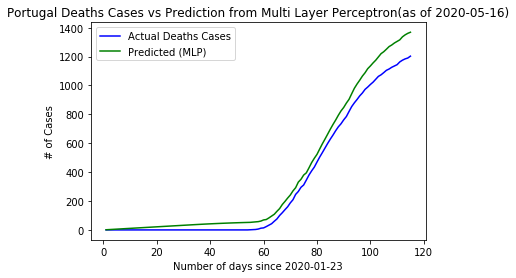

In [72]:
plot_predictions_for_country(
    new_df, "Portugal", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "Portugal Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 242.91234136070887
MSE: 101694.81490606227
RMSE: 318.89624473496434
R^2: 0.7543347483187453


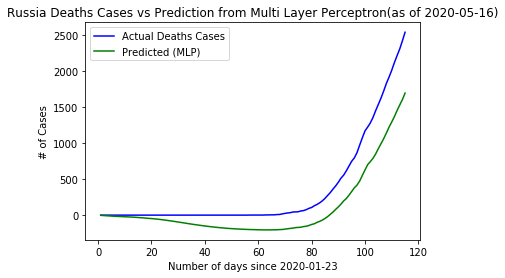

In [73]:
plot_predictions_for_country(
    new_df, "Russia", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "Russia Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 333.1299150533475
MSE: 224334.74042106117
RMSE: 473.6398847447934
R^2: 0.9984330811750942


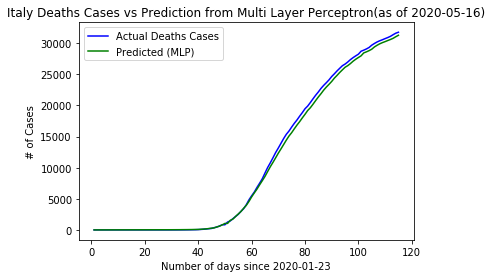

In [74]:
plot_predictions_for_country(
    new_df, "Italy", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (MLP)", 
    "Italy Deaths Cases vs Prediction from Multi Layer Perceptron",
    True
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


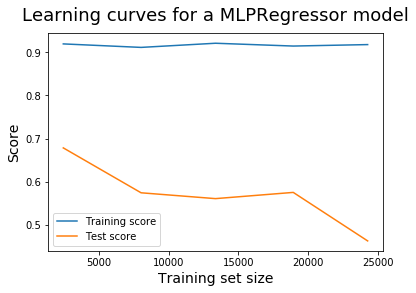

In [75]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)

## 3.4.3) Regression for Recovered Cases
### Using the best combination of parameters found for the recovered cases: for the Multi Layer Perceptron, the best option tested was using increases in confirmed cases and normalized values and using increases as output

In [95]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Recovered_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.12137308],
       [ 0.79830423, -0.03978737, -1.68731909, -0.12137308],
       [ 0.27177561, -0.30283255, -1.68731909, -0.12137308],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.12137308],
       [ 0.31790115,  1.38034566,  1.71718314, -0.12137308],
       [-1.65599721,  0.09994051,  1.71718314, -0.12137308]])

In [96]:
outputs = new_df["Recovered_inc"].values
outputs

array([ 0.,  0.,  0., ..., 59.,  0.,  0.])

In [97]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

In [98]:
mlp_estimator = mlp
fit_model(mlp_estimator, in_conf_train, out_conf_train)
mlp_estimator

Elapsed time: 1.1511146028836567mins


C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

MAE: 36.83080180785076
MSE: 43886.921130920346
RMSE: 209.49205505441094
R^2: 0.5954788679194352


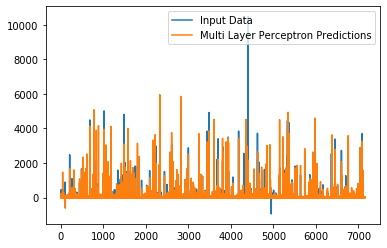

In [99]:
check_results_test(mlp_estimator, in_conf_test, out_conf_test, 'Multi Layer Perceptron Predictions')

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

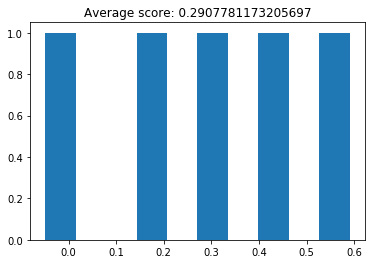

In [81]:
mlp_estimator_2 = clone(mlp_estimator)

plot_cross_val_score(mlp_estimator_2, inputs, outputs, 5)

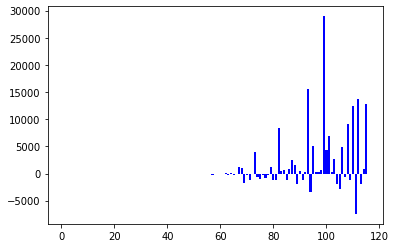

In [82]:
plot_pred_diff(
    new_df, mlp_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered_inc"
)

MAE: 13979.660876967158
MSE: 875612575.2042332
RMSE: 29590.75151469177
R^2: 0.8439682882981305


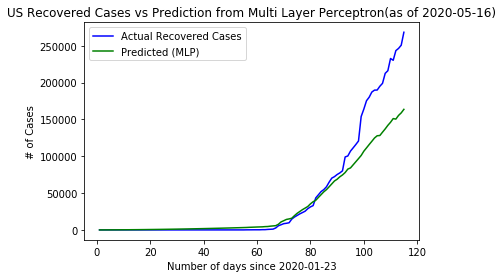

In [83]:
plot_predictions_for_country(
    new_df, "US", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "US Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 5025.489138705047
MSE: 87220205.90026376
RMSE: 9339.175868365675
R^2: 0.8277220835885738


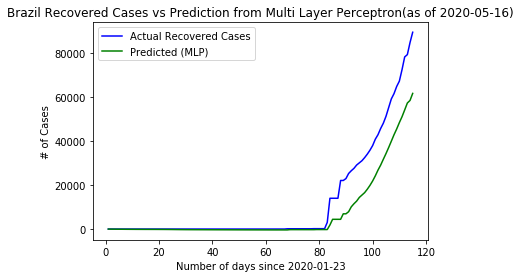

In [84]:
plot_predictions_for_country(
    new_df, "Brazil", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "Brazil Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 2703.356600832768
MSE: 17920172.562871158
RMSE: 4233.222479727608
R^2: 0.9926795032336012


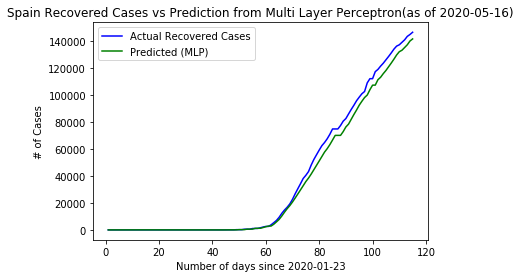

In [85]:
plot_predictions_for_country(
    new_df, "Spain", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "Spain Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 90.73231549920627
MSE: 35609.47709173503
RMSE: 188.7047352128055
R^2: 0.9562353436991826


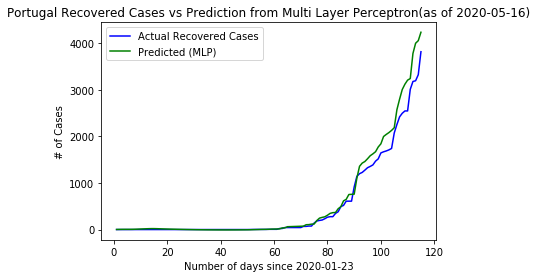

In [86]:
plot_predictions_for_country(
    new_df, "Portugal", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "Portugal Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 1792.2978354891725
MSE: 6694580.275239221
RMSE: 2587.3886981354813
R^2: 0.9585373911186091


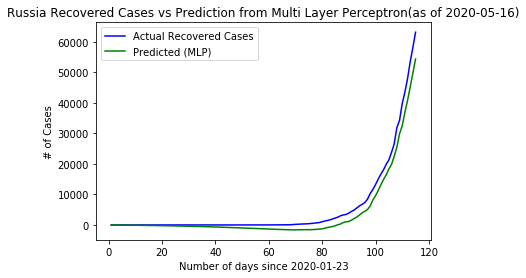

In [87]:
plot_predictions_for_country(
    new_df, "Russia", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "Russia Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

MAE: 928.4130998427262
MSE: 2647032.5370256086
RMSE: 1626.9703553001846
R^2: 0.9979313761449798


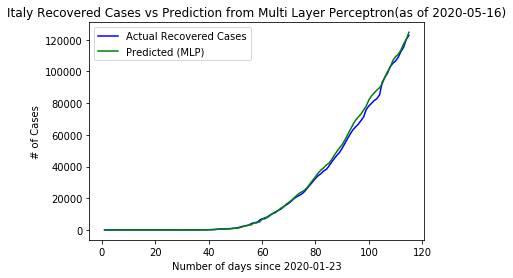

In [88]:
plot_predictions_for_country(
    new_df, "Italy", mlp_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (MLP)", 
    "Italy Recovered Cases vs Prediction from Multi Layer Perceptron",
    True
)

C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ptmig\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

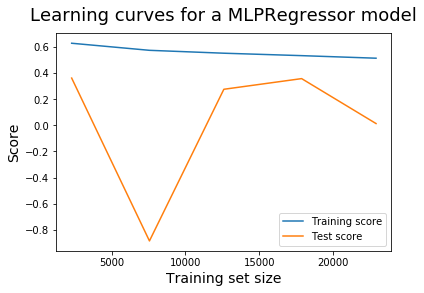

In [89]:
# learning curve
mlp_estimator_2 = clone(mlp_estimator)

plot_learning_curve(mlp_estimator_2, inputs, outputs)